# **1. Project Overview**

### *Project Description*
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

The challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, using F1 score between the predicted and expected answers.

### *Dataset Description*
The data consists of 10,000 hand classified tweets. Each sample in the train and test set has the following information:

- The `text` of a tweet
- A `keyword` from that tweet (may be blank)
- The `location` the tweet was sent from (may be blank)

If the tweet is predicted to be about a real disaster, the prediction is a `1`, if not, the prediction is a `0`.

#### **Files**
- **train.csv:** the training set
- **test.csv:** the test set
- **sample_submission.csv:** a sample submission file in the correct format

#### **Columns**

- `id` - a unique identifier for each tweet
- `text` - the text of the tweet
- `location` - the location the tweet was sent from (may be blank)
- `keyword` - a particular keyword from the tweet (may be blank)
- `target` - in **train.csv** only, this denotes whether a tweet is about a real disaster (1) or not (0)

---

# **2. Project Setup**

In [72]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [73]:
# IMPORT LIBRARIES
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

# For text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# For model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# For word embedding
import gensim
from gensim import models
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [74]:
# SET NOTEBOOK FORMATTING OPTIONS
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]

In [75]:
# READ IN DATA
test = pd.read_csv('../input/natural-language-processing-with-disaster-tweets/test.csv')
train = pd.read_csv('../input/natural-language-processing-with-disaster-tweets/train.csv')

---

# **3. Exploratory Data Analysis (EDA)**

In [76]:
# Preview training data
display(train)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### **3.1 Missing Values**

In [78]:
# Missing data check
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [79]:
# Replace NaNs with blanks
train=train.replace(np.nan, '')
train

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,,,Police investigating after an e-bike collided ...,1


### **3.2 Target Variables**
- `0`: Negative
- `1`: Positive (true disaster)

In [80]:
# Label counts
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

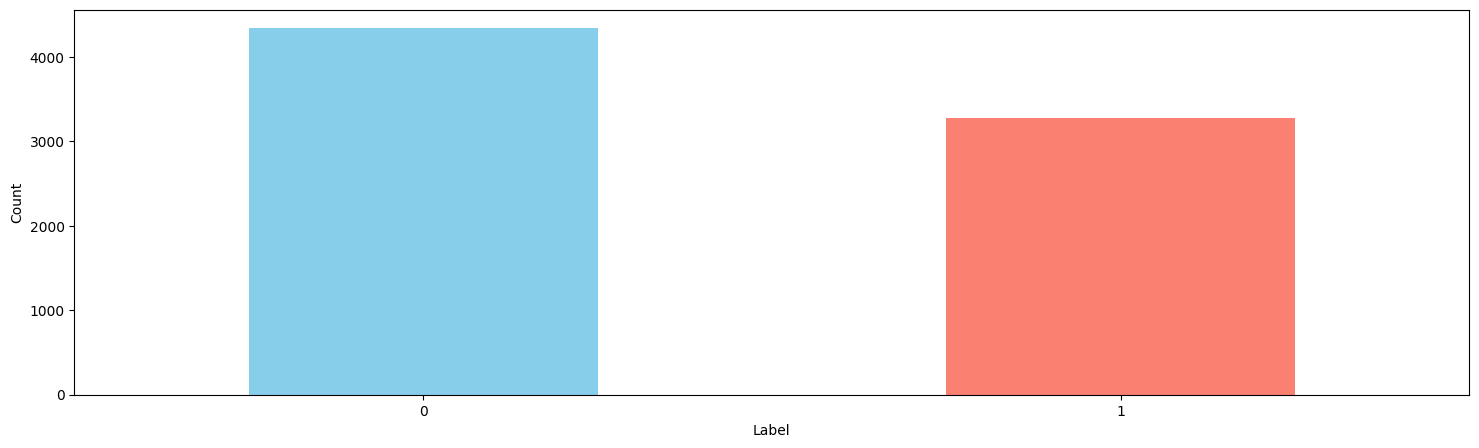

In [81]:
# Plot distribution of labels
train['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### **3.3 Distribution of Keywords**
Top 15 keywods.

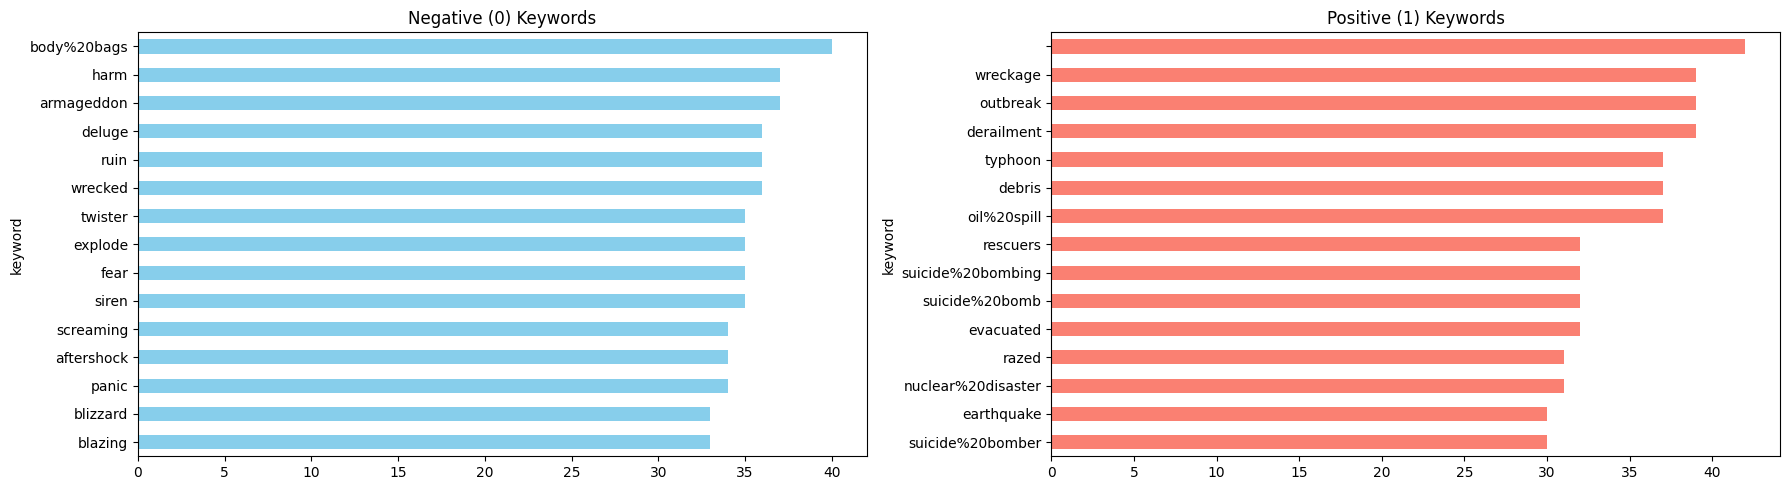

In [82]:
# Distribution of keywords: top 15 words
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
train['keyword'][train['target']==0].value_counts()[:15].plot(kind='barh', color='skyblue', title='Negative (0) Keywords').invert_yaxis()

plt.subplot(1, 2, 2)
train['keyword'][train['target']==1].value_counts()[:15].plot(kind='barh', color='salmon', title='Positive (1) Keywords').invert_yaxis()

plt.tight_layout()

### **3.4 Distribution of Locations**
Top 15 locations.

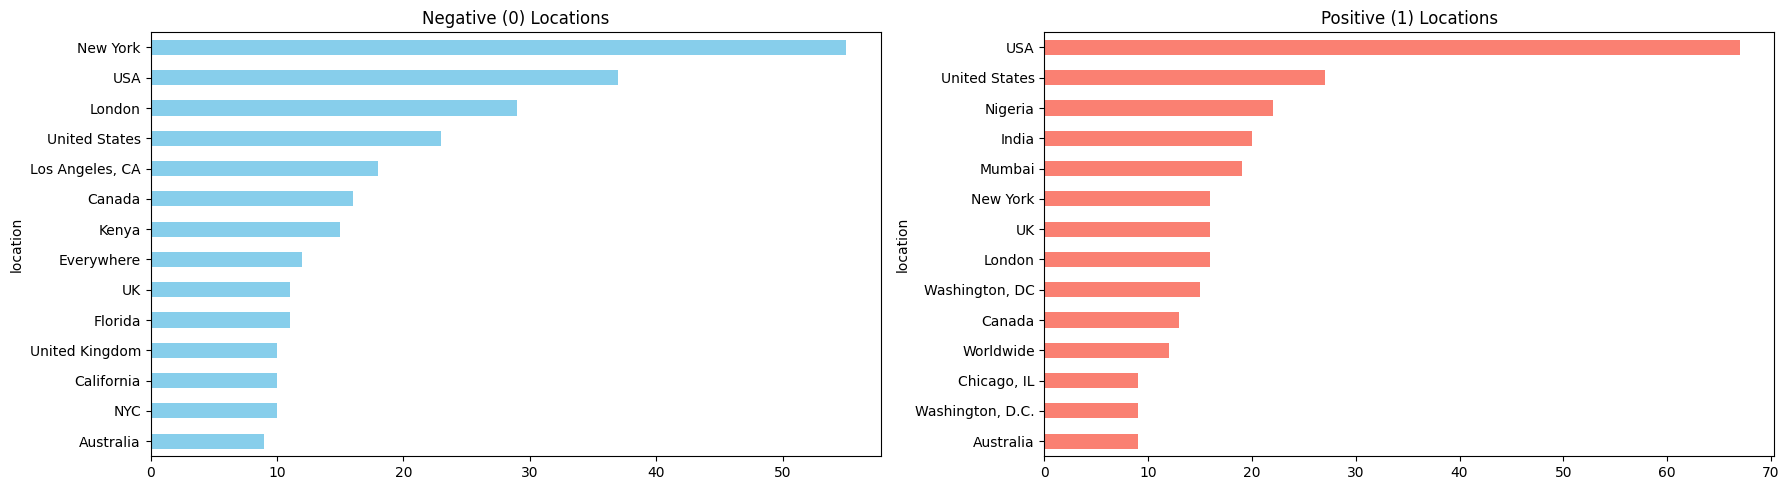

In [83]:
# Distribution of locations: top 15 locations
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
train['location'][train['target']==0].value_counts()[1:15].plot(kind='barh', color='skyblue', title='Negative (0) Locations').invert_yaxis()

plt.subplot(1, 2, 2)
train['location'][train['target']==1].value_counts()[1:15].plot(kind='barh', color='salmon', title='Positive (1) Locations').invert_yaxis()

plt.tight_layout()

### **3.5 Distribution of Word Counts**

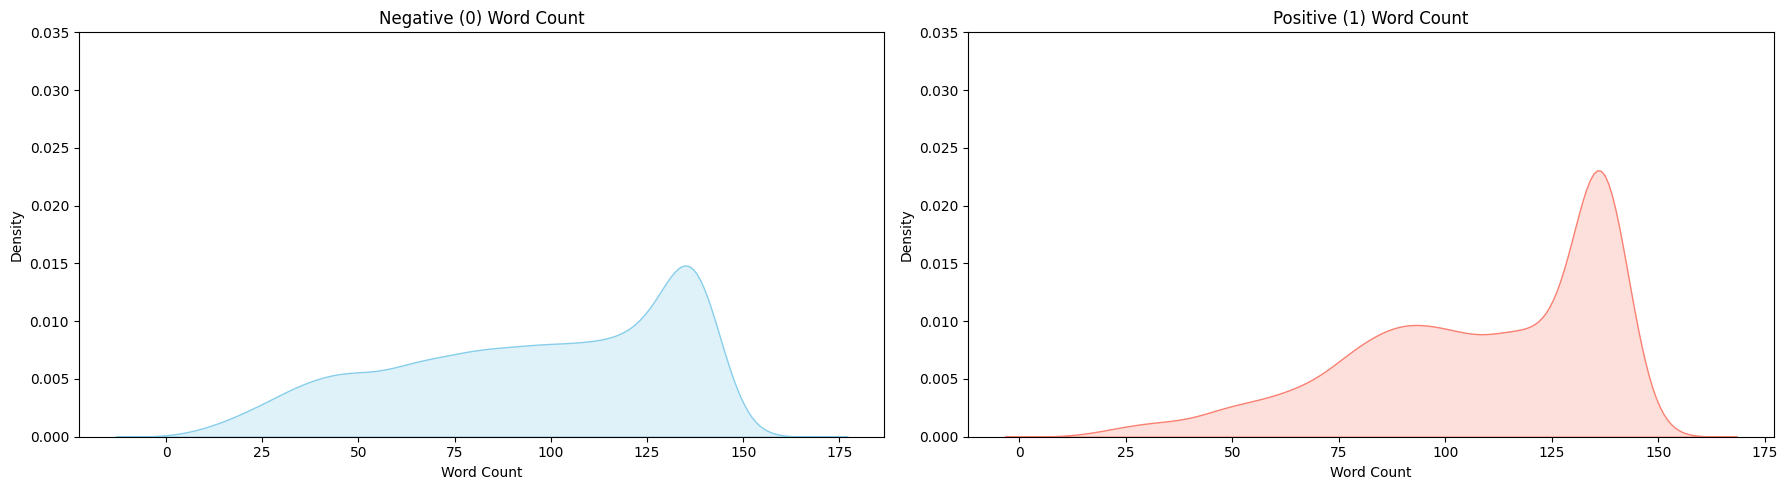

In [84]:
# Distribution of word counts
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(train['text'][train['target']==0].str.len(), color='skyblue', fill=True)
plt.title('Negative (0) Word Count')
plt.xlabel('Word Count')
plt.yticks([0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035])

plt.subplot(1, 2, 2)
sns.kdeplot(train['text'][train['target']==1].str.len(), color='salmon', fill=True)
plt.title('Positive (1) Word Count')
plt.xlabel('Word Count')
plt.yticks([0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035])

plt.tight_layout()

### **3.6 Distribution of Character Counts**

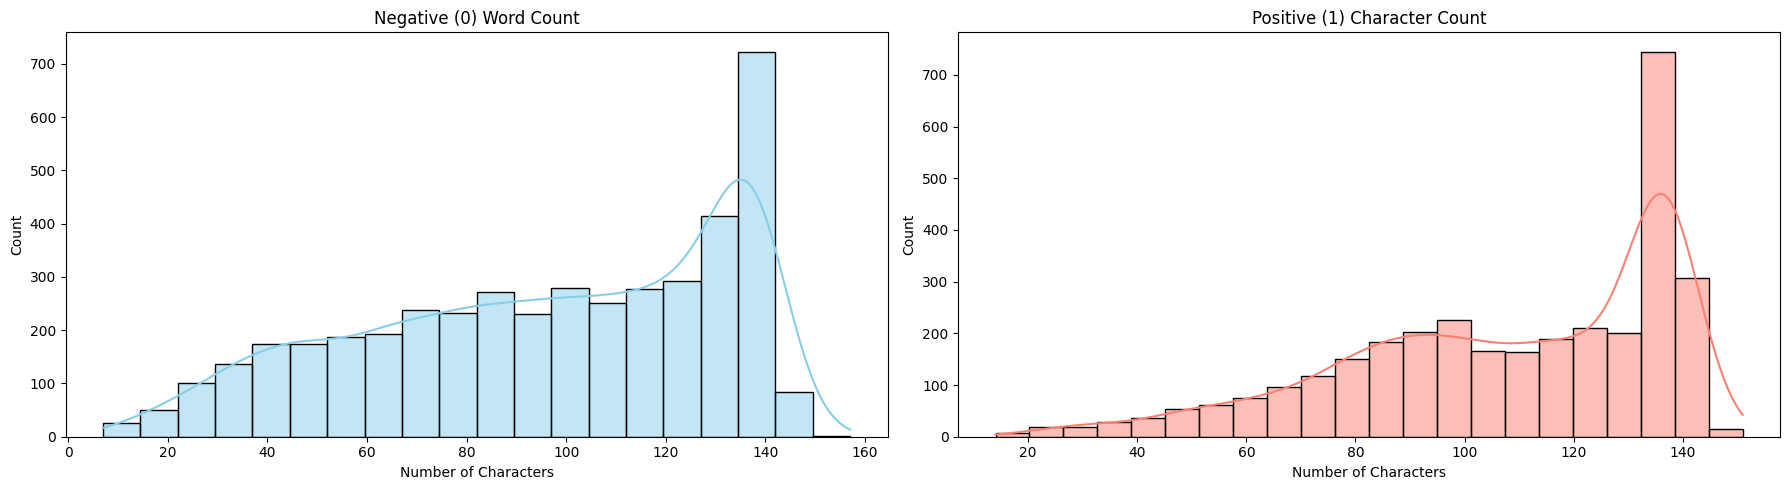

In [85]:
# Distribution of character counts
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
sns.histplot(train['text'][train['target']==0].apply(len), color='skyblue', kde=True)
plt.title('Negative (0) Word Count')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(train['text'][train['target']==1].apply(len), color='salmon', kde=True)
plt.title('Positive (1) Character Count')
plt.xlabel('Number of Characters')

plt.tight_layout()

---

# **4. Preprocessing**

In [86]:
# Subset training text
train_text = train['text']
train_text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

**Preprocessing function:** *Convert text to lowercase, strip, and remove punctuations from text*

In [87]:
# Function to convert to lowercase, strip and remove punctuations from text
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

**Remove stopwords**

In [88]:
# Function for removing stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

**Lemmatize text**

In [89]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()

In [90]:
# Helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

**Tokenize text**

In [91]:
# Function for tokenizing the text
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

**Final preprocessing**

In [92]:
# Function for final preprocessing
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [93]:
clean_text = train_text.apply(finalpreprocess)
clean_text

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       people receive wildfire evacuation order calif...
4       get sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    aria ahrary thetawniest control wild fire cali...
7610             utc km volcano hawaii http co zdtoyd ebj
7611    police investigate e bike collide car little p...
7612    late home raze northern california wildfire ab...
Name: text, Length: 7613, dtype: object

### **4.1 Word Cloud**

In [94]:
from wordcloud import WordCloud
from collections import Counter

In [95]:
wc = WordCloud(width=2400,
               height=1500,
               min_font_size=10,
               background_color='white')

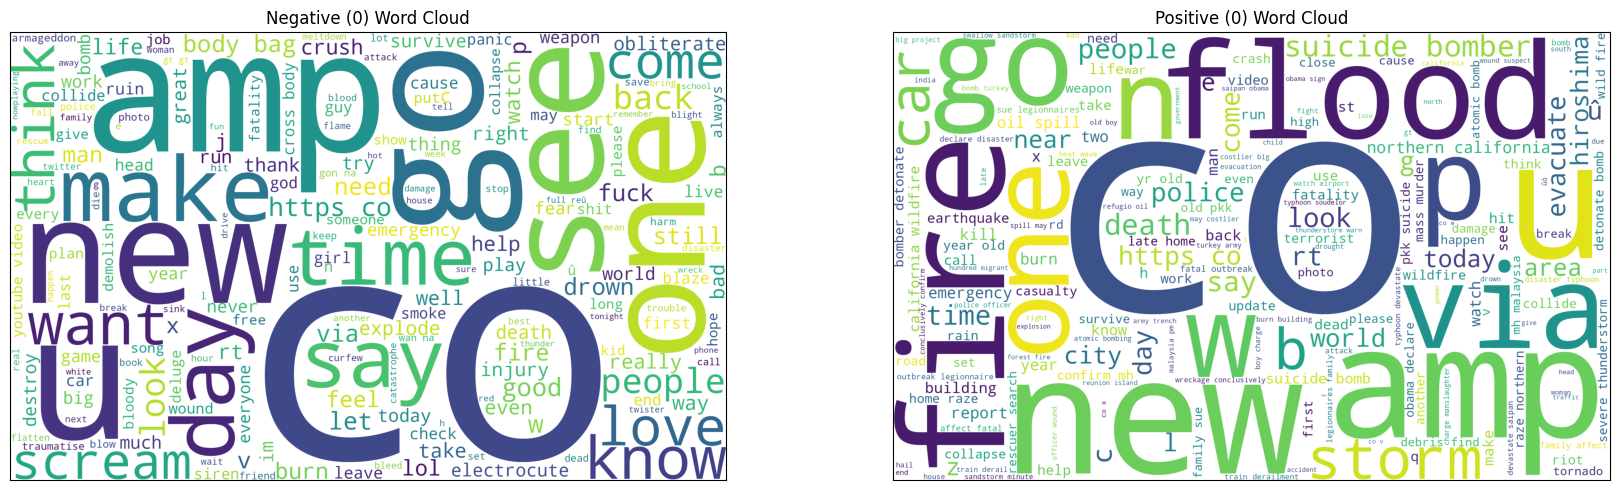

In [96]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
text_wc = wc.generate(clean_text[train['target']==0].str.cat(sep=" "))
plt.title('Negative (0) Word Cloud')
plt.xticks([])
plt.yticks([])
plt.imshow(text_wc)

plt.subplot(1, 2, 2)
text_wc = wc.generate(clean_text[train['target']==1].str.cat(sep=" "))
plt.title('Positive (0) Word Cloud')
plt.xticks([])
plt.yticks([])
plt.imshow(text_wc)

plt.tight_layout()

---

# **5. Vectorization**
Extract vectors from text. Using **Bag-of-Words (Tf-Idf)** and **Word2Vec.**

### **5.1 Training and Testing Data**

In [97]:
X_train, X_test, y_train, y_test = train_test_split(clean_text, train["target"], test_size=0.2, shuffle=True)

In [98]:
# Training and Testing data for Word2Vec
X_train_tok = [nltk.word_tokenize(i) for i in X_train]  
X_test_tok = [nltk.word_tokenize(i) for i in X_test]

### **5.2 Tf-Idf**

In [99]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

### **5.3 Word2Vec**

In [100]:
# Build Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [101]:
clean_text_tok = [nltk.word_tokenize(i) for i in clean_text]
model = Word2Vec(clean_text_tok, min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [102]:
# Convert text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

---

# **6. Classification (ML Algorithms)**
Train machine learning model on vectorized dataset. Using **Logistic Regression** and **Naive Bayes.** 

### **6.1 Logistic Regression**
Fit model using Logistic Regression (Tf-Idf).

In [103]:
lr_tfidf = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

LogisticRegression(C=10, solver='liblinear')

**Predictions**

In [104]:
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

**Classification Report**

In [105]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       896
           1       0.76      0.75      0.75       627

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



**Confusion Matrix**

In [106]:
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

Confusion Matrix: [[749 147]
 [159 468]]


**ROC-AUC**

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

AUC: 0.8658604964114831


In [108]:
# Save metrics for model comparison
lr_f1 = metrics.f1_score(y_true=y_test, y_pred=y_predict)
lr_acc = metrics.accuracy_score(y_true=y_test, y_pred=y_predict)
lr_auc = roc_auc

---

### **6.2 Naive Bayes (Tf-Idf)**
Fit classification model using Naive Bayes (Tf-Idf).

In [109]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

MultinomialNB()

**Predictions**

In [110]:
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

**Classification Report**

In [111]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       896
           1       0.85      0.67      0.75       627

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523



**Confusion Matrix**

In [112]:
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

Confusion Matrix: [[824  72]
 [205 422]]


**ROC-AUC**

In [113]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.8645949034518112


In [114]:
# Save metrics for model comparison
nb_f1 = metrics.f1_score(y_true=y_test, y_pred=y_predict)
nb_acc = metrics.accuracy_score(y_true=y_test, y_pred=y_predict)
nb_auc = roc_auc

---

# **7. Model Selection**
Estimate target values for the unlabelled test data using the best model.

In [115]:
# Highest F1-Score
print([lr_f1, nb_f1].index(max([lr_f1, nb_f1])), max([lr_f1, nb_f1]))

0 0.7536231884057971


*The **Logistic Regression** model had the higher F1-Score of 0.75.*

In [116]:
# Highest accuracy score
print([lr_acc, nb_acc].index(max([lr_acc, nb_acc])), max([lr_acc, nb_acc]))

1 0.8181221273801708


*The **Logistic Regression** model had the higher accuracy score of 0.79.*

In [117]:
# Highest AUC
print([lr_auc, nb_auc].index(max([lr_auc, nb_auc])), max([lr_auc, nb_auc]))

0 0.8658604964114831


*The **Naive Bayes** model had the higher AUC of 0.84.*

---
The best model for predicting the target value for the test data is **Logistic Regression.**

---

**Preprocess test data**

In [118]:
# Subset test text
test_text = test['text']
test_text

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [119]:
test_text = test_text.apply(lambda x: finalpreprocess(x))
X_test = test_text
X_test

0                               happen terrible car crash
1       heard earthquake different city stay safe ever...
2       forest fire spot pond geese flee across street...
3                       apocalypse light spokane wildfire
4                      typhoon soudelor kill china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety fasten...
3259    storm ri bad last hurricane city amp others ha...
3260     green line derailment chicago http co utbxlcbiuy
3261    meg issue hazardous weather outlook hwo http c...
3262    cityofcalgary activate municipal emergency pla...
Name: text, Length: 3263, dtype: object

In [120]:
# Convert text to numerical data using Tf-Idf
X_vector = tfidf_vectorizer.transform(X_test)

**Use the best model to predict the target value for new dataset**

In [121]:
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

# **8. Conclusion**

This project built a text classification model comparing Bag-of-Words (with Tf-Idf) and Word Embedding (with Word2Vec) to classify disaster tweets. The best model for classifying disaster tweets was **Logistic Regression**, with a F1-Score of 0.75 and an accuracy score of 0.79.

Further improvements may include the use of other classification algorithms, such as SVM and neural networks and hyperparameter tuning.

---

# **9. Submission**

In [122]:
# Create submission dataframe
submission = pd.DataFrame({'target': y_predict}, index=test['id'])
submission

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [123]:
submission.to_csv('submission.csv', index=False)